In [2]:
import pandas as pd
import os
from omegaconf import DictConfig 
from inference.read_report import ReportProcessor
from inference.compute_post_scores import ComputePostScore
import hydra
from hydra.utils import instantiate
from inference.visualization import DataVisualization
from inference.performance_statistics import *

In [2]:
def run_computation(cfg:DictConfig):
    processor = ReportProcessor(cfg)
    result_df = processor.read_metric_reports()
    InD_scenarios= load_scenario_types_from_csv('scenario_type_counts.csv')
    labeled_df = label_scenarios(result_df, InD_scenarios) 
    compute_postscore=ComputePostScore(labeled_df, cfg)
    energy_score = compute_postscore.get_min_score()
    average_energy_score = compute_postscore.calculate_average_ood_score()
    visualizer = DataVisualization(figsize=(12, 8), alpha=0.6, grid=True)
    visualizer.draw_distribution(average_energy_score, score='ood_score_avg')

In [52]:
CONFIG_PATH = 'inference/config'
CONFIG_NAME = 'runner_report'
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
# cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['split=test','planner=planTF', 'job_name=open_loop_boxes'])
cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=open_loop_boxes'])
# cfg = hydra.compose(config_name=CONFIG_NAME)
# cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=closed_loop_reactive_agents'])
processor = ReportProcessor(cfg)
result_df = processor.read_metric_reports()

In [53]:
result_df=calculate_average_metric_score(result_df)
result_df=label_low_score(result_df)

KeyError: "None of [Index(['planner_expert_average_heading_error_within_bound',\n       'planner_expert_average_l2_error_within_bound',\n       'planner_expert_final_heading_error_within_bound',\n       'planner_expert_final_l2_error_within_bound',\n       'planner_miss_rate_within_bound'],\n      dtype='object')] are in the [columns]"

In [38]:
def add_risk_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'risk_label' column to the DataFrame. If any boolean metric is less than 1, 
    set 'risk_label' to True; otherwise, set it to False.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - boolean_metrics (list): List of boolean metric column names.

    Returns:
    - pd.DataFrame: The input DataFrame with an additional 'risk_label' column.
    """
    boolean_metrics =[
    'no_ego_at_fault_collisions',  
    'drivable_area_compliance',
     'driving_direction_compliance',  
    'time_to_collision_within_bound',
    'ego_progress_along_expert_route',
    'ego_is_making_progress',
    'ego_is_comfortable',
    'speed_limit_compliance']

    # Ensure all metrics exist in the DataFrame
    missing_metrics = [metric for metric in boolean_metrics if metric not in df.columns]
    if missing_metrics:
        raise ValueError(f"The following metrics are missing from the DataFrame: {missing_metrics}")
    
    # Create the 'risk_label' column: True if any boolean metric < 1, False otherwise
    df['risk_label'] = (df[boolean_metrics] < 0.5).any(axis=1)

    return df

In [54]:
result_df = add_risk_label(result_df)

In [55]:
InD_scenarios= load_scenario_types_from_csv('scenario_type_counts.csv')
labeled_df = label_scenarios(result_df, InD_scenarios) 

In [4]:
compute_postscore=ComputePostScore(labeled_df, cfg)
mean_score= compute_postscore.get_var_score()
average_mean_score = compute_postscore.calculate_average_ood_score()

NameError: name 'labeled_df' is not defined

In [10]:
plantf_ind = count_low_risk_ind_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
stopping_at_stop_sign_without_lead          369
on_stopline_stop_sign                       365
starting_unprotected_cross_turn             363
on_carpark                                  362
on_stopline_crosswalk                       339
on_stopline_traffic_light                   314
high_lateral_acceleration                   276
on_intersection                             274
on_pickup_dropoff                           272
on_traffic_light_intersection               261
following_lane_without_lead                 257
stopping_at_crosswalk                       250
traversing_crosswalk                        224
traversing_pickup_dropoff                   208
near_barrier_on_driveable                   199
near_trafficcone_on_driveable               184
near_pedestrian_on_crosswalk                168
near_multiple_vehicles                      161
medium_magnitude_speed                      159
traversing_intersection  

In [47]:
game_ind_close_reactive=count_low_risk_ind_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
near_barrier_on_driveable                   282
on_stopline_stop_sign                       244
traversing_pickup_dropoff                   226
stopping_at_stop_sign_without_lead          209
on_pickup_dropoff                           197
near_multiple_vehicles                      189
on_intersection                             170
on_stopline_traffic_light                   162
traversing_crosswalk                        160
near_trafficcone_on_driveable               155
high_lateral_acceleration                   152
stopping_at_crosswalk                       152
on_stopline_crosswalk                       143
starting_unprotected_cross_turn             122
on_carpark                                  118
on_traffic_light_intersection               112
medium_magnitude_speed                      108
traversing_traffic_light_intersection       105
traversing_intersection                      99
near_pedestrian_on_crossw

In [36]:
game_ind_open=count_low_risk_ind_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
stopping_at_stop_sign_without_lead          407
starting_unprotected_cross_turn             393
on_stopline_stop_sign                       313
on_stopline_traffic_light                   284
on_carpark                                  282
on_stopline_crosswalk                       279
high_lateral_acceleration                   273
stopping_at_crosswalk                       266
on_traffic_light_intersection               259
on_pickup_dropoff                           235
on_intersection                             228
traversing_pickup_dropoff                   228
traversing_crosswalk                        203
near_barrier_on_driveable                   193
near_trafficcone_on_driveable               180
traversing_traffic_light_intersection       166
near_pedestrian_on_crosswalk                157
medium_magnitude_speed                      145
near_long_vehicle                           131
near_multiple_vehicles   

In [49]:
find_common_scenario_types(game_ind_open,game_ind_close_reactive)

                               scenario_type  plantf_count  gameformer_count
0         stopping_at_stop_sign_without_lead           407               209
1            starting_unprotected_cross_turn           393               122
2                      on_stopline_stop_sign           313               244
3                  on_stopline_traffic_light           284               162
4                                 on_carpark           282               118
5                      on_stopline_crosswalk           279               143
6                  high_lateral_acceleration           273               152
7                      stopping_at_crosswalk           266               152
8              on_traffic_light_intersection           259               112
9                          on_pickup_dropoff           235               197
11                 traversing_pickup_dropoff           228               226
10                           on_intersection           228               170

,scenario_type,plantf_count,gameformer_count
0,stopping_at_stop_sign_without_lead,407,209
1,starting_unprotected_cross_turn,393,122
2,on_stopline_stop_sign,313,244
3,on_stopline_traffic_light,284,162
4,on_carpark,282,118
5,on_stopline_crosswalk,279,143
6,high_lateral_acceleration,273,152
7,stopping_at_crosswalk,266,152
8,on_traffic_light_intersection,259,112
9,on_pickup_dropoff,235,197


In [13]:
def count_low_risk_ood_types(df: pd.DataFrame) -> None:
    """
    Count the occurrences of 'scenario_type' for rows where:
    - 'risk_label' is True
    - 'scenario_distribution' is 'InD'

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing 'risk_label' and 'scenario_distribution' columns.
    """
    if 'risk_label' not in df.columns or 'scenario_distribution' not in df.columns:
        raise ValueError("The DataFrame must contain 'risk_label' and 'scenario_distribution' columns.")
    
    # Filter rows where risk_label is True and scenario_distribution is 'InD'
    low_risk_ood_df = df[(df['risk_label'] == False) & (df['scenario_distribution'] == 'OOD')]

    # Count occurrences of each scenario_type
    scenario_counts = low_risk_ood_df['scenario_type'].value_counts()

    # Print the counts
    print("Scenario type counts for low-risk InD scenarios:")
    print(scenario_counts)
    return scenario_counts

In [14]:
plantf_ood=count_low_risk_ood_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
unknown                                                   365
following_lane_with_lead                                  307
stopping_at_traffic_light_without_lead                    258
behind_bike                                               198
starting_protected_cross_turn                             189
starting_right_turn                                       184
waiting_for_pedestrian_to_cross                           170
starting_straight_stop_sign_intersection_traversal        163
accelerating_at_traffic_light_with_lead                   160
starting_unprotected_noncross_turn                        121
stopping_at_stop_sign_no_crosswalk                         26
changing_lane_to_right                                     22
behind_pedestrian_on_driveable                             15
crossed_by_vehicle                                         14
starting_straight_traffic_light_intersection_traversal     10
high_ma

In [56]:
game_ood=count_low_risk_ood_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
unknown                                                   395
waiting_for_pedestrian_to_cross                           383
following_lane_with_lead                                  336
stopping_at_traffic_light_without_lead                    317
starting_unprotected_noncross_turn                        242
behind_bike                                               229
starting_straight_stop_sign_intersection_traversal        209
starting_right_turn                                       186
accelerating_at_traffic_light_with_lead                   183
starting_protected_cross_turn                             180
stopping_at_stop_sign_no_crosswalk                        113
changing_lane_to_right                                     29
crossed_by_vehicle                                         17
starting_straight_traffic_light_intersection_traversal     14
changing_lane_to_left                                      13
acceler

In [50]:
game_ood_activate=count_low_risk_ood_types(result_df)

Scenario type counts for low-risk InD scenarios:
scenario_type
unknown                                                   415
waiting_for_pedestrian_to_cross                           358
stopping_at_traffic_light_without_lead                    298
following_lane_with_lead                                  281
starting_unprotected_noncross_turn                        245
behind_bike                                               236
starting_protected_cross_turn                             234
starting_straight_stop_sign_intersection_traversal        202
accelerating_at_traffic_light_with_lead                   173
starting_right_turn                                       165
stopping_at_stop_sign_no_crosswalk                        133
changing_lane_to_right                                     32
accelerating_at_crosswalk                                  22
crossed_by_vehicle                                         18
starting_straight_traffic_light_intersection_traversal     16
changin

In [57]:
find_common_scenario_types(game_ood, game_ood_activate)

                                        scenario_type  plantf_count  \
0                                             unknown           395   
1                     waiting_for_pedestrian_to_cross           383   
2                            following_lane_with_lead           336   
3              stopping_at_traffic_light_without_lead           317   
4                  starting_unprotected_noncross_turn           242   
5                                         behind_bike           229   
6   starting_straight_stop_sign_intersection_trave...           209   
7                                 starting_right_turn           186   
8             accelerating_at_traffic_light_with_lead           183   
9                       starting_protected_cross_turn           180   
10                 stopping_at_stop_sign_no_crosswalk           113   
11                             changing_lane_to_right            29   
12                                 crossed_by_vehicle            17   
13  st

,scenario_type,plantf_count,gameformer_count
0,unknown,395,415
1,waiting_for_pedestrian_to_cross,383,358
2,following_lane_with_lead,336,281
3,stopping_at_traffic_light_without_lead,317,298
4,starting_unprotected_noncross_turn,242,245
5,behind_bike,229,236
6,starting_straight_stop_sign_intersection_trave...,209,202
7,starting_right_turn,186,165
8,accelerating_at_traffic_light_with_lead,183,173
9,starting_protected_cross_turn,180,234


In [51]:
find_common_scenario_types(plantf_ood, game_ood_activate)

                                        scenario_type  plantf_count  \
0                                             unknown           365   
1                            following_lane_with_lead           307   
2              stopping_at_traffic_light_without_lead           258   
3                                         behind_bike           198   
4                       starting_protected_cross_turn           189   
5                                 starting_right_turn           184   
6                     waiting_for_pedestrian_to_cross           170   
7   starting_straight_stop_sign_intersection_trave...           163   
8             accelerating_at_traffic_light_with_lead           160   
9                  starting_unprotected_noncross_turn           121   
10                 stopping_at_stop_sign_no_crosswalk            26   
11                             changing_lane_to_right            22   
12                     behind_pedestrian_on_driveable            15   
13    

,scenario_type,plantf_count,gameformer_count
0,unknown,365,415
1,following_lane_with_lead,307,281
2,stopping_at_traffic_light_without_lead,258,298
3,behind_bike,198,236
4,starting_protected_cross_turn,189,234
5,starting_right_turn,184,165
6,waiting_for_pedestrian_to_cross,170,358
7,starting_straight_stop_sign_intersection_trave...,163,202
8,accelerating_at_traffic_light_with_lead,160,173
9,starting_unprotected_noncross_turn,121,245


In [11]:
def find_common_scenario_types(plantf_ind, gameformer_ind):
    """
    Find and count the common scenario types between plantf_ind and gameformer_ind.

    Parameters:
    - plantf_ind (pd.Series): A Pandas Series containing scenario types and their counts for plantf_ind.
    - gameformer_ind (pd.Series): A Pandas Series containing scenario types and their counts for gameformer_ind.

    Returns:
    - pd.DataFrame: A DataFrame with common scenario types and their counts in both plantf_ind and gameformer_ind.
    """
    # Convert the Series to DataFrames for easy manipulation
    plantf_df = plantf_ind.reset_index()
    gameformer_df = gameformer_ind.reset_index()

    # Rename columns for clarity
    plantf_df.columns = ['scenario_type', 'plantf_count']
    gameformer_df.columns = ['scenario_type', 'gameformer_count']

    # Merge the two DataFrames on 'scenario_type' to find common types
    common_df = pd.merge(plantf_df, gameformer_df, on='scenario_type', how='inner')

    # Sort the result by scenario_type or counts (optional)
    common_df = common_df.sort_values(by=['plantf_count', 'gameformer_count'], ascending=False)
    print(common_df)
    return common_df

In [12]:
find_common_scenario_types(plantf_ind, game_ind)

                               scenario_type  plantf_count  gameformer_count
0         stopping_at_stop_sign_without_lead           369               407
1                      on_stopline_stop_sign           365               313
2            starting_unprotected_cross_turn           363               393
3                                 on_carpark           362               282
4                      on_stopline_crosswalk           339               279
5                  on_stopline_traffic_light           314               284
6                  high_lateral_acceleration           276               273
7                            on_intersection           274               228
8                          on_pickup_dropoff           272               235
9              on_traffic_light_intersection           261               259
10               following_lane_without_lead           257               105
11                     stopping_at_crosswalk           250               266

,scenario_type,plantf_count,gameformer_count
0,stopping_at_stop_sign_without_lead,369,407
1,on_stopline_stop_sign,365,313
2,starting_unprotected_cross_turn,363,393
3,on_carpark,362,282
4,on_stopline_crosswalk,339,279
5,on_stopline_traffic_light,314,284
6,high_lateral_acceleration,276,273
7,on_intersection,274,228
8,on_pickup_dropoff,272,235
9,on_traffic_light_intersection,261,259


In [26]:
print(game_ind)

None


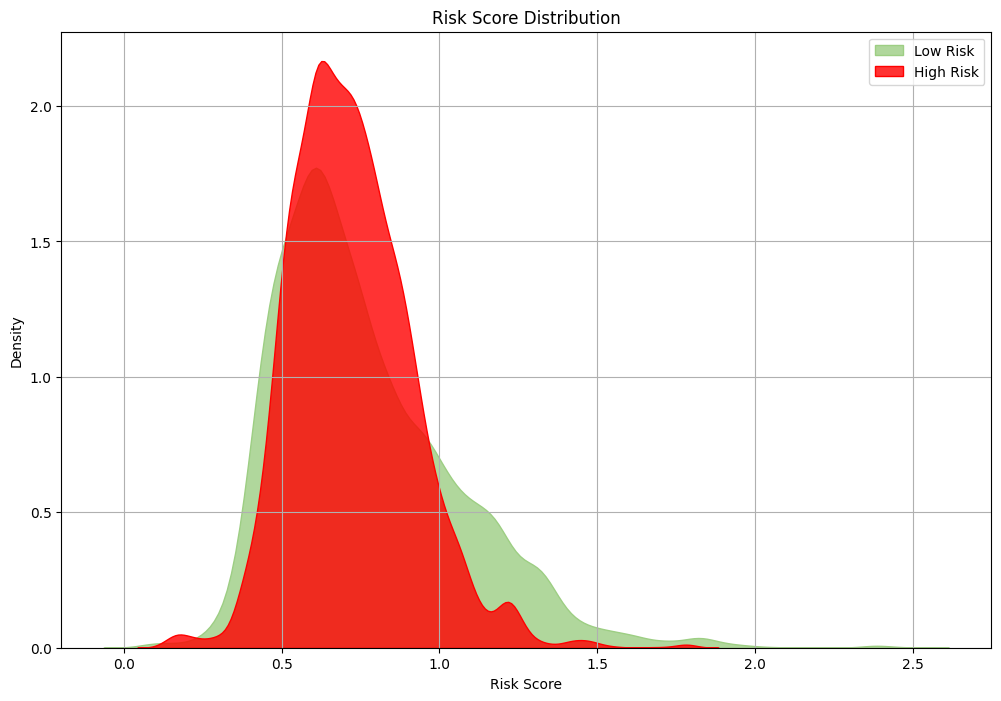

In [14]:
visualizer = DataVisualization(figsize=(12, 8), alpha=0.8, grid=True)
visualizer.draw_risk(average_mean_score, score='ood_score_avg')

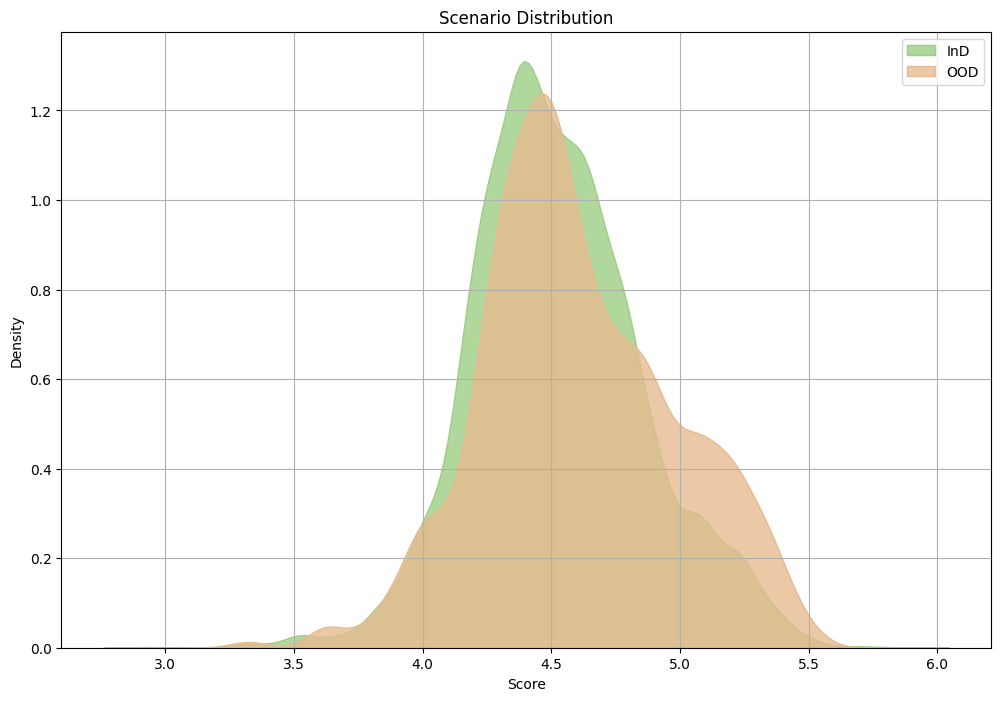

In [13]:
visualizer = DataVisualization(figsize=(12, 8), alpha=0.8, grid=True)
visualizer.draw_distribution(average_mean_score, score='ood_score_avg')

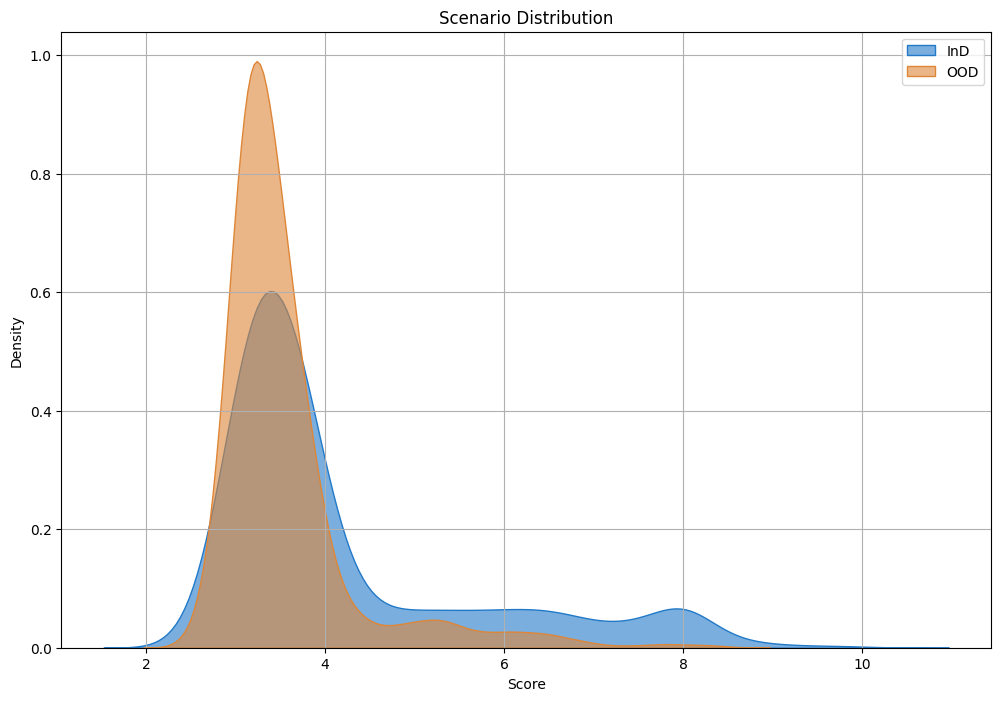

In [8]:
cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['planner=planTF', 'job_name=open_loop_boxes'])
run_computation(cfg)

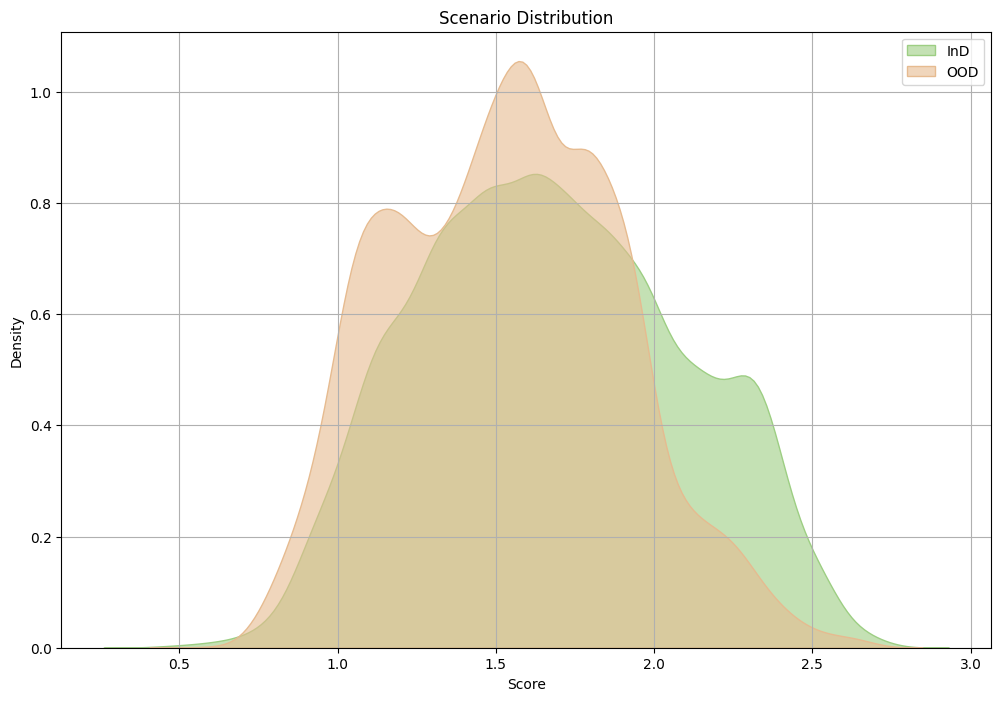

In [17]:
cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=open_loop_boxes'])
run_computation(cfg)

/home/sgwang/data/tmp/envs/plantf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sgwang/data/tmp/envs/plantf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


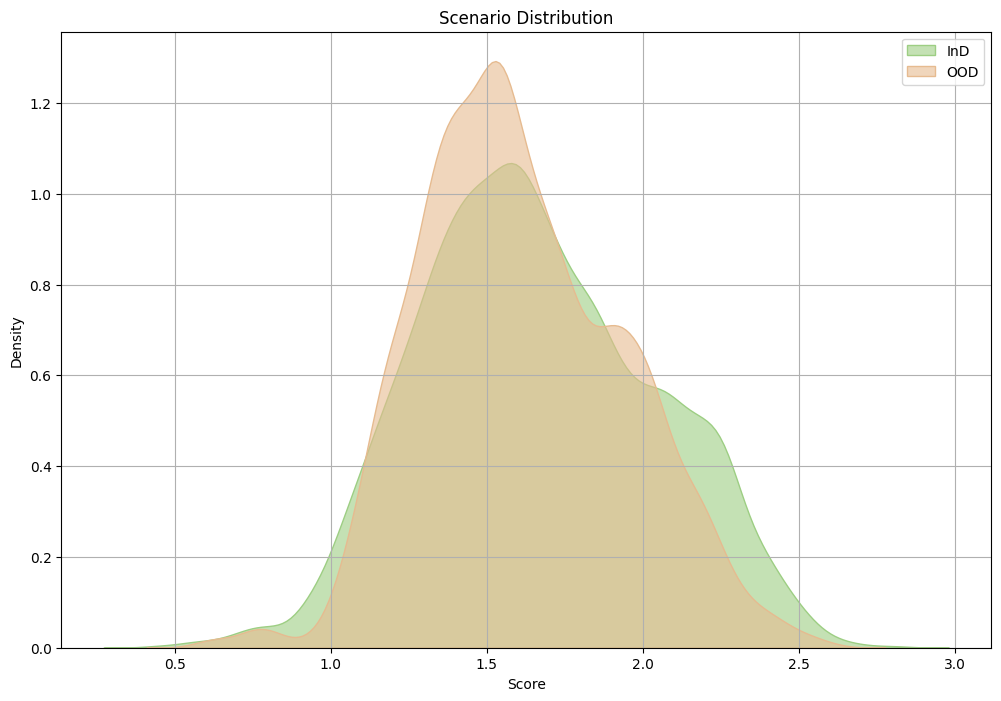

In [18]:
cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=closed_loop_reactive_agents'])
run_computation(cfg)